In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
sns.set_style('white')
sns.set_context('talk')
import numpy as np
import pandas as pd
import collections
import addict

In [3]:
name = 'free-energy-vs-time'

In [41]:
hvm_fname = pathlib.Path('/Users/jaan/log/transfer_tigergpu/log.csv')
out_path = pathlib.Path('/Users/jaan/Dropbox/100_projects/vi-for-physics/doc/notes/hierarchical-elbo/fig/')
df = pd.read_csv(hvm_fname)
log_dict = addict.Dict()

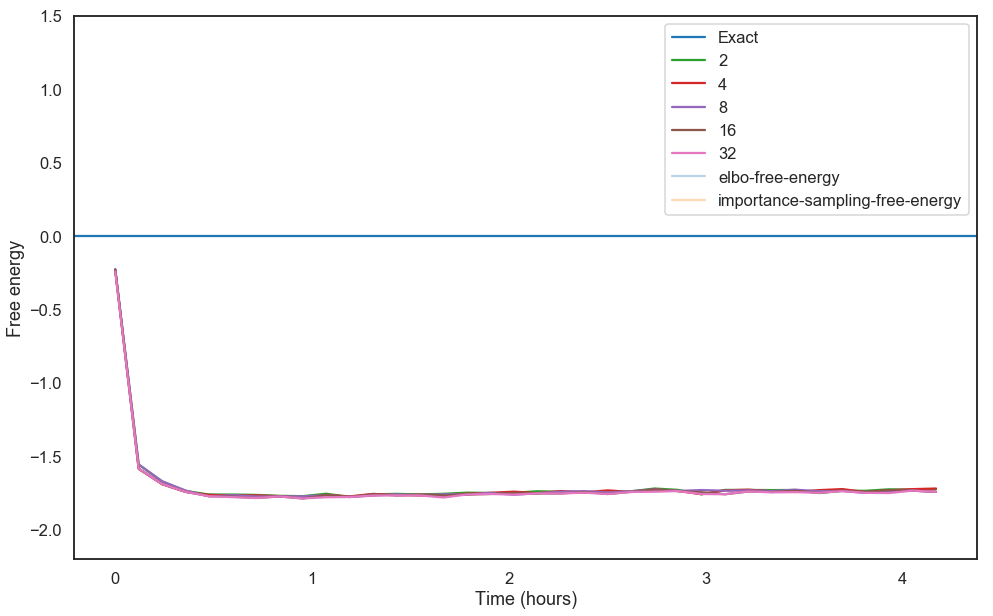

In [46]:
fig, ax = plt.subplots(figsize=(10 * 1.618, 10))
ax.axhline(y=df['true_free_energy'].values[0], label='Exact')
for name in [('elbo-free-energy'),# 'eldo-free-energy-std'),
                       ('importance-sampling-free-energy')
                       #'importance-sampling-std')
                       ]:
  sub_df = df[[name, std_name, 'compute_time']].dropna()
  sub_df['time'] = sub_df.compute_time.cumsum() / 60 / 60
  ax.errorbar(sub_df.time, sub_df[name],
              #yerr=sub_df[std_name],
              label=name,
              alpha=0.3)

for k in df.k.dropna().unique():
  sub_df = df.loc[df.k == k]
  sub_df = sub_df[['importance-bound-free-energy', 'compute_time']].dropna()
  sub_df['time'] = sub_df.compute_time.cumsum() / 60 / 60  
  ax.plot(sub_df.time, sub_df['importance-bound-free-energy'], label=int(k))
ax.legend()
ax.set(xlabel='Time (hours)', ylabel='Free energy', ylim=[-2.2, 1.5])
plt.savefig(out_path / 'test.pdf')

In [16]:
van_dir = pathlib.Path('/Users/jaan/log/transfer_tigergpu/2019-06-23/test/stat-mech-van')
for f in van_dir.rglob('*.csv'):
  name = f.parts[-3]
  if 'periodic' in name:
    system_size = int(name.split('L')[1][:2])
    beta = float(name.split('beta')[1])
    log_dict['van'][system_size][beta] = f

In [6]:
log_dict = log_dict.to_dict()

In [7]:
df_dict = {}
for method in ['van', 'hvm']:
  df_dict[method] = {}
  for system_size in log_dict[method].keys():
    df_dict[method][system_size] = {}
    for beta in log_dict[method][system_size].keys():
#      if beta != 1.0:
      df = pd.read_csv(
        log_dict[method][system_size][beta],
        header=None,
        usecols=range(2),
        names=['step', 'free_energy'])
      if method == 'van':
        df.step = df.step.apply(lambda x: int(x.split('=')[1]))
        df.free_energy = df.free_energy.apply(lambda x: float(x.split('=')[1]))
      # convert using 6h runtime to timepoints
      df['time'] = df.step * (6 * 60 * 60 / df.step.values[-1])
      df_dict[method][system_size][beta] = df

In [8]:
labels = {'van': 'VAN', 'hvm': 'HVM'}
linestyle = {'van': '--', 'hvm': '-'}
palettes = {'van': sns.light_palette('orange', reverse=True, n_colors=4),
            'hvm': sns.light_palette('blue', reverse=True, n_colors=4)}
sizes_to_plot = [16, 32, 64]
for beta in df_dict['hvm'][16].keys():
  fig, ax = plt.subplots(figsize=(5 * 1.618, 5))
  for method in ['hvm', 'van']:
    for i, system_size in enumerate(sizes_to_plot):
      df = df_dict[method][system_size][beta]
      label = f'{labels[method]} L={system_size}'
      ax.plot(df.time.values / 60 / 60,
                  df.free_energy.values,
                  label=label,
                  color=palettes[method][i],
                  linestyle=linestyle[method],
      )
  ax.legend()
  ax.set_ylim([-2.2, -0.5])
  ax.set_xlim([0, 6])
  ax.set(xlabel='Time (hours)', ylabel='Free energy')
  ax.yaxis.grid()
  sns.despine(right=True, left=True)
  plt.savefig(f'../../doc/notes/hierarchical-elbo/fig/{name}_beta={beta}.pdf', bbox_inches='tight')
  plt.close()
